In [12]:
# MC
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
from scipy.integrate import odeint
import scipy.stats as stats
import seaborn as sns

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
from __future__ import division
import datetime
localtime = datetime.datetime.now().strftime("%Y_%m_%d")


In [2]:
def kin(S,y,t):
    temp=288.
    kH2 = 4.27E-13*np.exp(-1240./temp)*((temp/298.)**2.406)
    fracland = 0.05
    kdep = 2e-4/1000*fracland # deposition at 0.2mm s-1 over 1km BLH
    kCH4 = 5e-15
    kCO = 2e-13
    kX = 1.
    yr_in_secs = 360.*24.*3600
    kloss = 1./(2.5*yr_in_secs)
    SH2, SCH4, SCO, SOH = S
    H2, CH4, CO, OH = y
    dH2  = SH2  - kdep*H2 - kH2*OH*H2
    dCH4 = SCH4 - kCH4*OH*CH4
    dCO  = SCO  - kCO*OH*CO + kCH4*OH*CH4
    dOH  = SOH  - kX*OH - kCH4*OH*CH4 - kCO*OH*CO - kH2*OH*H2
    return dH2, dCH4, dCO, dOH

def kin_cr(S,y,t):
    yr_in_secs = 360.*24.*3600
    temp=288.
    kH2 = 4.27E-13*np.exp(-1240./temp)*((temp/298.)**2.406)
    fixedrem = 59.20*1e9/5e18*28.8/2.*2.5e19/yr_in_secs # 59 Tg per year loss rate
    kCH4 = 5e-15
    kCO = 2e-13
    kX = 1.
    yr_in_secs = 360.*24.*3600
    kloss = 1./(2.5*yr_in_secs)
    SH2, SCH4, SCO, SOH = S
    H2, CH4, CO, OH = y
    dH2  = SH2  - fixedrem - kH2*OH*H2
    dCH4 = SCH4 - kCH4*OH*CH4
    dCO  = SCO  - kCO*OH*CO + kCH4*OH*CH4
    dOH  = SOH  - kX*OH - kCH4*OH*CH4 - kCO*OH*CO - kH2*OH*H2
    return dH2, dCH4, dCO, dOH

In [3]:
def integrate_box(S, initial_concs, fin, starttime, nyrs):
    from functools import partial 
    ppbv_to_per_cm3 = 2.5e10
    yr_in_s = 60.*60.*24.*365.
    SH2_in_Tg, SCH4_in_Tg, SCO_in_Tg, SOH_in_cm3_per_sec = S
    SH2 = SH2_in_Tg*1e9/5e18*28.8/2.*2.5e19/yr_in_s
    SCH4 = SCH4_in_Tg*1e9/5e18*28.8/16.*2.5e19/yr_in_s
    SCO = SCO_in_Tg*1e9/5e18*28.8/30.*2.5e19/yr_in_s
    SOH = SOH_in_cm3_per_sec
    Sinit = np.array([SH2, SCH4, SCO, SOH])
    
    H2i, CH4i, COi, OHi = initial_concs
    yinit  = np.array([H2i*ppbv_to_per_cm3, CH4i*ppbv_to_per_cm3, COi*ppbv_to_per_cm3 , OHi])
    
    time = np.linspace(start=0.0, stop=nyrs*yr_in_s, num=nyrs*12*30)
    y2 =  odeint(partial(fin,Sinit), yinit,  time)

    times = pd.date_range(start=starttime, periods=nyrs*12*30, freq='D')
    H2 =  pd.Series(data=y2[:,0]/ppbv_to_per_cm3, index=times)
    CH4 = pd.Series(data=y2[:,1]/ppbv_to_per_cm3, index=times)
    CO =  pd.Series(data=y2[:,2]/ppbv_to_per_cm3, index=times)
    OH =  pd.Series(data=y2[:,3], index=times)
    return H2, CH4, CO, OH
init = np.array([0., 0., 0., 0.])

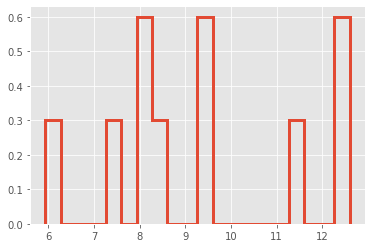

In [4]:
# Using numpy
import numpy.random as npr
mu, sigma = 9, 2.5 # mean and standard deviation
rs = npr.normal(mu, sigma, size=10)
plt.hist(rs, bins=20, histtype='step', density=True, linewidth=3, label='leak of 9 +/- 2.5 Tg');

In [5]:
def calc_range(Sleak, sigma_leak, Santhro, sigma_anthro, SVOC_oxid, sigma_VOC_oxid):
    SBB = 15. # Biomass burning
    SN2 = 8. # N2 fixation is 8 Tg
    Soceans = 4. # ref
    nsize=25
    rleak = npr.normal(Sleak, sigma_leak, size=nsize)
    ranthro =npr.normal(Santhro, sigma_anthro, size=nsize)
    roxid = npr.normal(SVOC_oxid, sigma_VOC_oxid, size=nsize)

    SCH4 = 520.
    SCO = 1370.
    SOH = 1.17e6
    
    H2_cs = np.zeros(nsize*nsize*nsize)
    H2_dp = np.zeros(nsize*nsize*nsize)
    H2_so = np.zeros(nsize*nsize*nsize)
    cvar=0
    for lvar in range(0,nsize):
        print(lvar)
        for vvar in range(0,nsize):
            for avar in range(0,nsize):
                SH2 = rleak[lvar] +  roxid[vvar] + ranthro[avar] + Soceans + SBB + SN2 #Tg H2 per year
                H2base_cr, CH4base_cr, CObase_cr, OHbase_cr    = integrate_box(S=np.array([SH2, SCH4, SCO, SOH]), 
                                   initial_concs=init,
                                   fin= kin_cr, starttime= '1/1/2000' , nyrs=100.)

                H2base_dep, CH4base_dep, CObase_dep, OHbase_dep    = integrate_box(S=np.array([SH2, SCH4,SCO, SOH]), 
                                   initial_concs=init,
                                   fin= kin, starttime= '1/1/2000' ,    nyrs=100.)
                H2_cs[cvar] = H2base_cr[-1]
                H2_dp[cvar] = H2base_dep[-1]
                H2_so[cvar] = SH2
                cvar=cvar+1
    return H2_cs, H2_dp, H2_so

In [6]:
H2_cs_lo, H2_dp_lo, H2_so_lo = calc_range(9, 2.5, 17., 5., 36., 5. )
H2_cs_hi, H2_dp_hi, H2_so_hi = calc_range(90., 25., 17., 5., 36., 5. )

0


/home/ptg21/.conda/envs/basemap3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [25]:
lo_source = np.array([H2_cs_lo, H2_dp_lo, H2_so_lo])
np.save( 'Low_scenario.npy', lo_source)

In [27]:
hi_source = np.array([H2_cs_hi, H2_dp_hi, H2_so_hi])
np.save( 'High_scenario.npy', hi_source)

In [19]:
mpl.rc('figure', figsize=(15,8),facecolor='white', dpi=300)
mpl.rc('figure.subplot', wspace= 0.4, hspace=0.2)
mpl.rc('figure.subplot', hspace= 0.2)
mpl.rc('axes', grid=1, titlesize=20)
mpl.rc('axes.formatter',limits=(-2,5))
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=10)

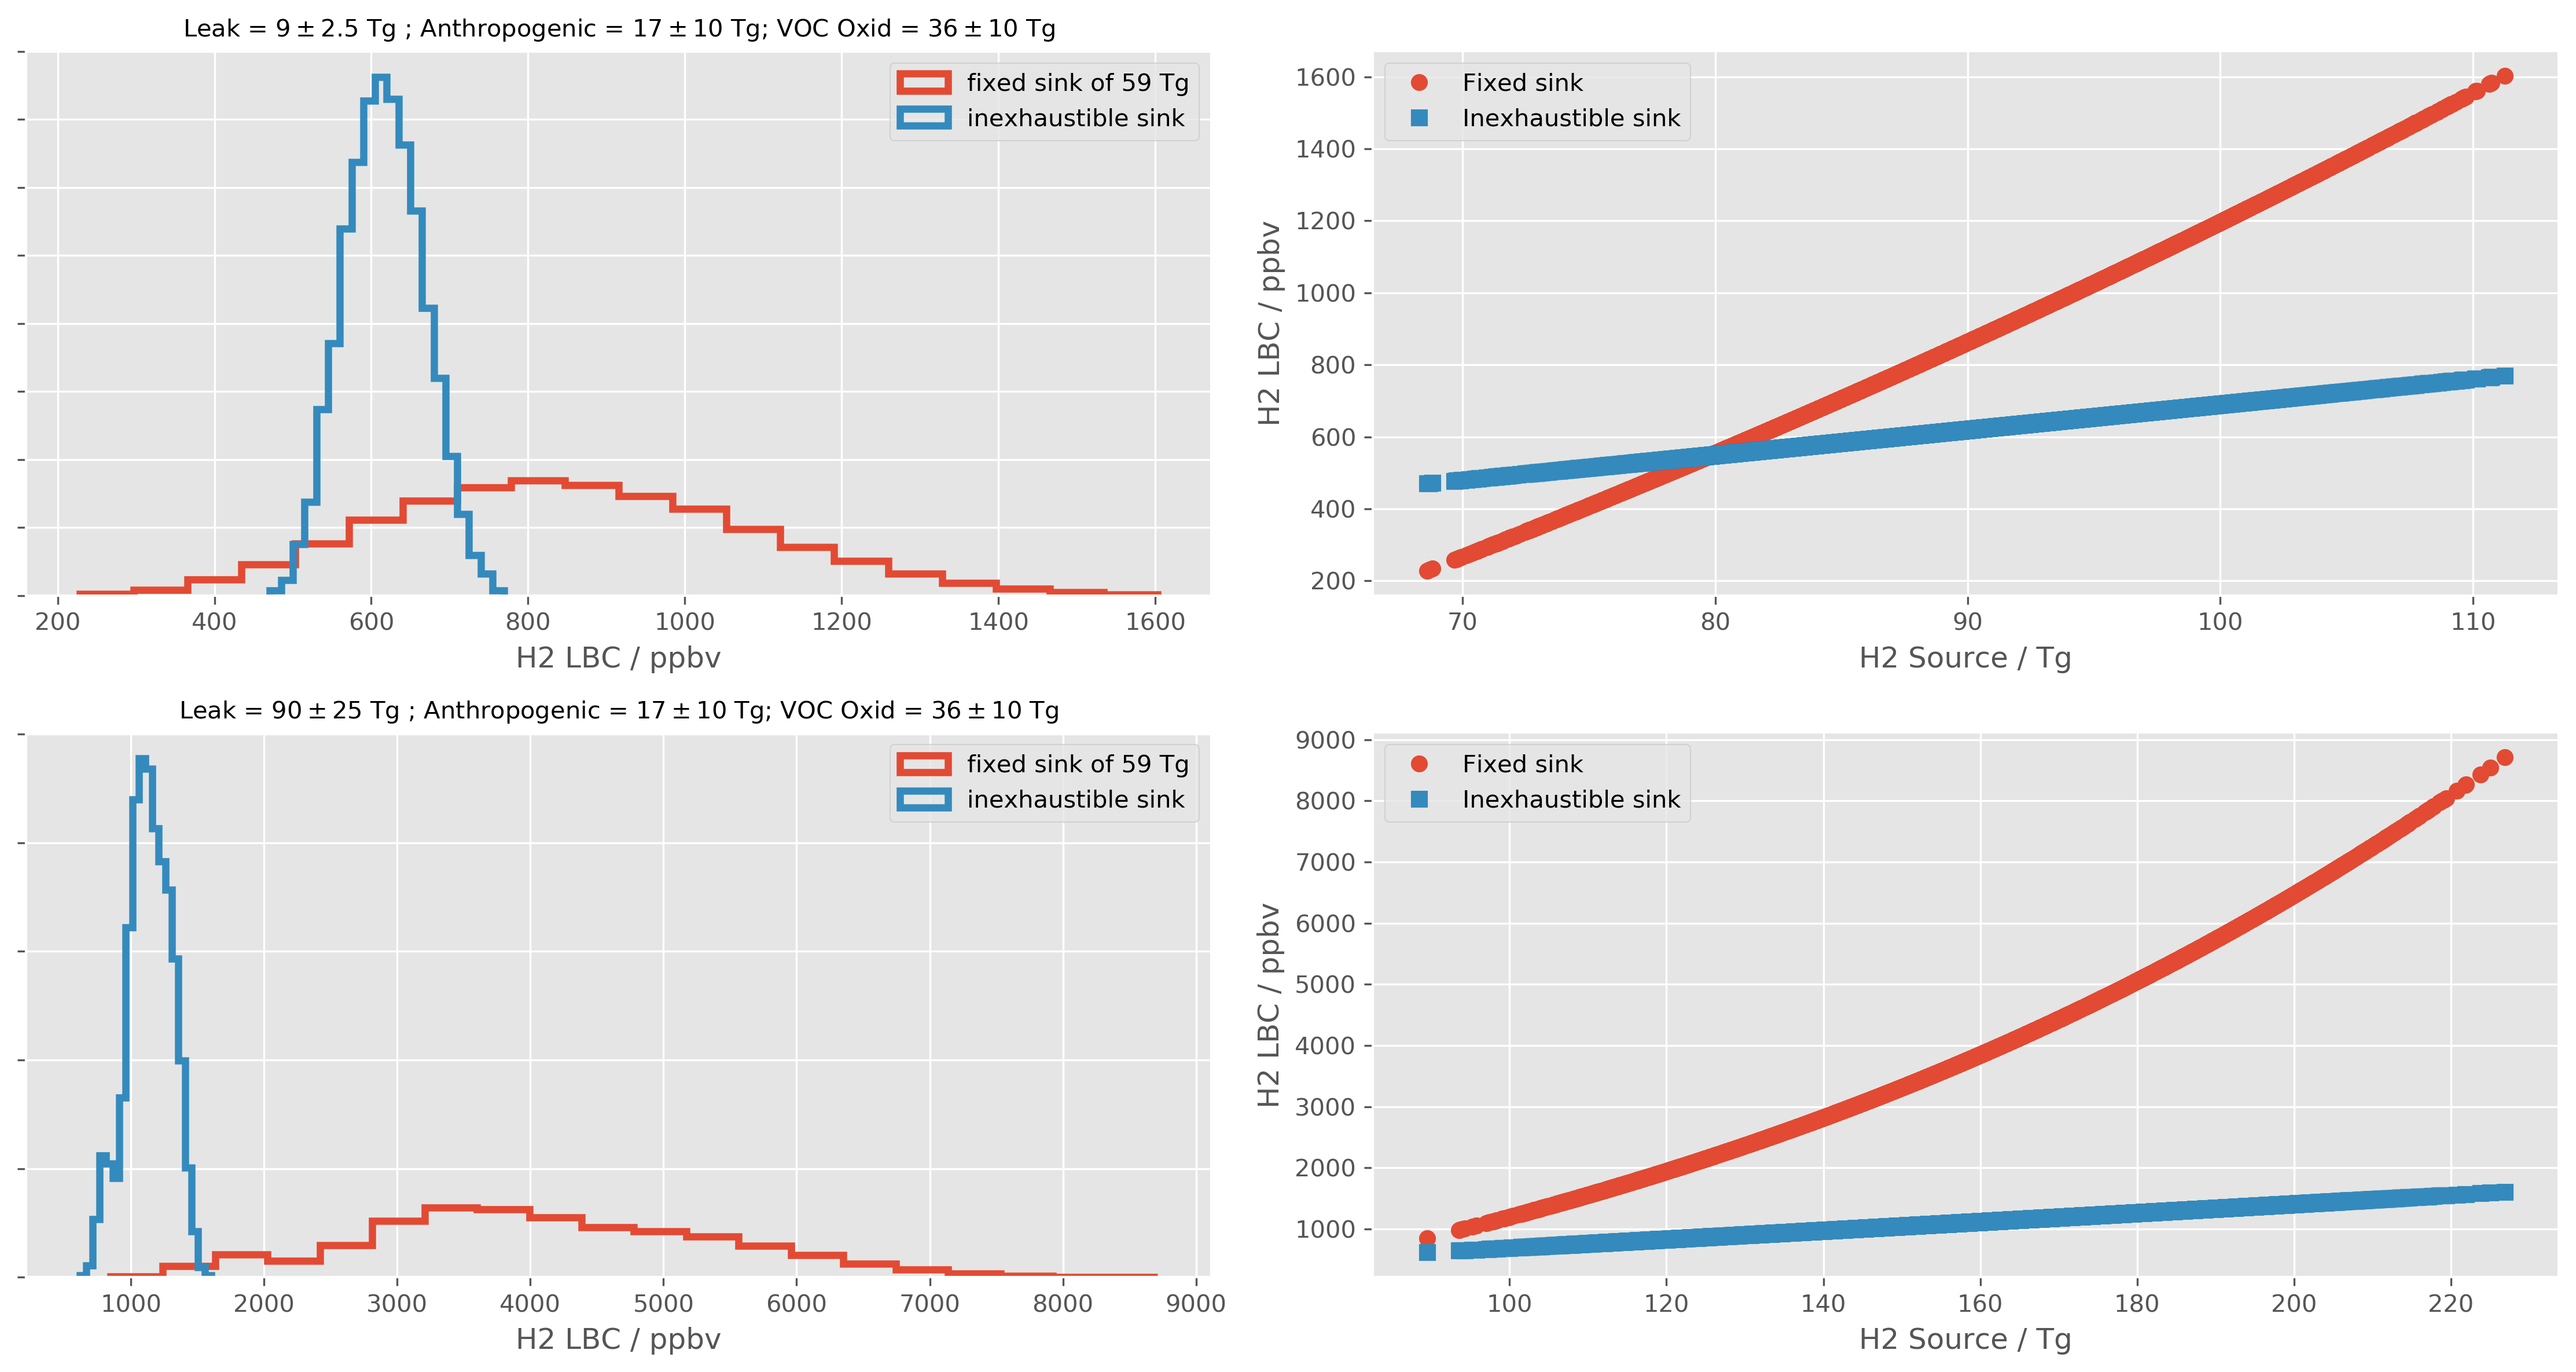

In [20]:
plt.subplot(2,2,1)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
plt.hist(H2_cs_lo, bins=20, histtype='step', density=True, linewidth=3, label='fixed sink of 59 Tg');
plt.hist(H2_dp_lo, bins=20, histtype='step', density=True, linewidth=3, label='inexhaustible sink');
plt.legend()
plt.xlabel('H2 LBC / ppbv')

plt.title('Leak = $9 \pm 2.5$ Tg ; Anthropogenic = $17 \pm 10$ Tg; VOC Oxid = $36 \pm 10$ Tg', fontsize =10) 

plt.subplot(2,2,2)
plt.plot(H2_so_lo, H2_cs_lo, 'o', label='Fixed sink')
plt.plot(H2_so_lo, H2_dp_lo, 's', label='Inexhaustible sink')
plt.xlabel('H2 Source / Tg')
plt.ylabel('H2 LBC / ppbv')
plt.legend()

plt.subplot(2,2,3)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

plt.hist(H2_cs_hi, bins=20, histtype='step', density=True, linewidth=3, label='fixed sink of 59 Tg');
plt.hist(H2_dp_hi, bins=20, histtype='step', density=True, linewidth=3, label='inexhaustible sink');
plt.legend()
plt.xlabel('H2 LBC / ppbv')
plt.title('Leak = $90 \pm 25$ Tg ; Anthropogenic = $17 \pm 10$ Tg; VOC Oxid = $36 \pm 10$ Tg', fontsize =10)  

plt.subplot(2,2,4)
plt.plot(H2_so_hi, H2_cs_hi, 'o', label='Fixed sink')
plt.plot(H2_so_hi, H2_dp_hi, 's', label='Inexhaustible sink')
plt.xlabel('H2 Source / Tg')
plt.ylabel('H2 LBC / ppbv')
plt.legend()
plt.tight_layout()